# Simulated Annealing with "light" basis vectors
--------------

Build a basis made of vectors with small Hamming weight.

Run Simulated Annealing with Monte Carlo move consisting of: 
* express the current configuration by means of basis expansion coefficients
* pick a coefficient at random and flip it
* get the new state

In [3]:
include("../code/headers.jl")

## Close look at one iteration

### 0. Slowly-varying beta 

In [17]:
q = 2
n = 500
m = 200
randseed = 1
rng = MersenneTwister(randseed)
lm = LossyModel(q, n, m, randseed=randseed)

beta2 = collect(LinRange(5e-1, 5e0, 100000))
nbetas = length(beta2)
nsamples = 1
mc_move = MetropBasisCoeffs()
# Initalize options for SA
algo = SA(mc_move, beta2, nsamples=nsamples, init_state=fix_indep_from_src)

# Allocate arrays for distortions and acceptances
distortions = [fill(0.5, algo.nsamples) for _ in 1:size(algo.betas,1)]
acceptance_ratios = [falses(algo.nsamples) for _ in 1:size(algo.betas,1)]
dE = [zeros(algo.nsamples) for _ in 1:size(algo.betas,1)];

In [18]:
solve!(lm, algo, distortions, acceptance_ratios)

SAResults
  parity: Int64 0
  distortion: Float64 0.144
  acceptance_ratio: Array{Float64}((100000,)) [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  beta_argmin: Array{Float64}((2,)) [Inf, 3.7270272702727025]
  converged: Bool true


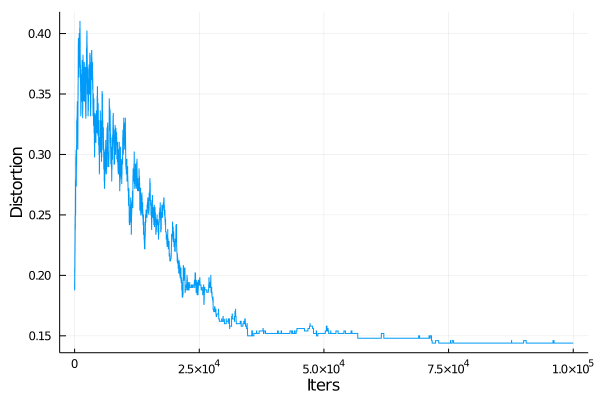

Distortion: 0.144
Naive compression: 0.199
RDB :0.079


In [19]:
display(plot([d[1] for d in distortions], xlabel="Iters", ylabel="Distortion", label=""))
println("Distortion: ", minimum(minimum.(distortions)))
println("Naive compression: ", naive_compression_inv(rate(lm)))
println("RDB :", round(rdbinv(rate(lm)), digits=3))

### 1. Starting from the zero codeword

In [38]:
q = 2
n = 500
m = 200
randseed = 1
rng = MersenneTwister(randseed)
lm = LossyModel(q, n, m, randseed=randseed)
lm

Lossy compression model:
 - Factor Graph with n=500 variables and m=200 factors defined on GF(2)
 - Inverse temperatures β₁=Inf for checks and β₂=1.0 for overlap


In [39]:
beta2 = [5e-1, 1e0, 2e0, 5e0]        # overlap temperature for simulated annealing
nbetas = length(beta2)
nsamples = 10000
mc_move = MetropBasisCoeffs()
# Initalize options for SA
algo = SA(mc_move, beta2, nsamples=nsamples)

SA
  mc_move: MetropBasisCoeffs
  betas: Array{Float64}((4, 2)) [Inf 0.5; Inf 1.0; Inf 2.0; Inf 5.0]
  nsamples: Int64 10000
  sample_every: Int64 1
  stop_crit: crit (function of type var"#crit#1519")
  init_state: init (function of type var"#init#1520")


In [40]:
# Initialize basis and basis coefficients
adapt_to_model!(algo.mc_move, lm)
# Initalize arrays to store distortion, etc.
distortions = [fill(0.5, algo.nsamples) for _ in 1:size(algo.betas,1)]
accepted = [falses(algo.nsamples) for _ in 1:size(algo.betas,1)]
dE = [zeros(algo.nsamples) for _ in 1:size(algo.betas,1)]
# Loop over betas
for b in 1:nbetas
    # Update temperature
    lm.beta1, lm.beta2 = algo.betas[b,1], algo.betas[b,2]
    # Start sampling
    for n in 1:algo.nsamples
        accepted[b][n], dE[b][n] = onemcstep!(lm , algo.mc_move, rng) 
        distortions[b][n] = distortion(lm)
    end
end

In [41]:
steps = 1:nsamples
pl = [Plots.Plot() for b in 1:2*nbetas]
for b in 1:size(algo.betas,1) 
    pl[b] = plot(steps, dE[b]*beta2[b], label="β=$(beta2[b])", xlabel="Iters", ylabel="ΔE*β")
    scatter!(pl[b], steps[accepted[b]], (dE[b]*beta2[b])[accepted[b]], color=:red, ms=2, label="Accepted")
    pl[b+nbetas] = plot(steps, distortions[b], xlabel="Iters", ylabel="Distortion", label="β=$(beta2[b])")
end
display(plot(pl..., layout = (2,nbetas), size=(900,400)))
println("Distortion: ", minimum(minimum.(distortions)))
println("Naive compression: ", naive_compression_inv(rate(lm)))
println("RDB :", round(rdbinv(rate(lm)), digits=3))

Distortion: 0.182
Naive compression: 0.199
RDB :0.079


### 2. Starting from the 'naive compression' line

In [13]:
q = 2
n = 500
m = 200
randseed = 1
rng = MersenneTwister(randseed)
lm = LossyModel(q, n, m, randseed=randseed)
lm

0.602

In [88]:
beta2 = [5e-1, 1e0, 2e0, 5e0]        # overlap temperature for simulated annealing
nbetas = length(beta2)
nsamples = 1000
mc_move = MetropBasisCoeffs()
# Initalize options for SA
betas = hcat(fill(Inf, length(beta2)), beta2)
algo = SA(mc_move, beta2, nsamples=nsamples)

SA
  mc_move: MetropBasisCoeffs
  betas: Array{Float64}((4, 2)) [Inf 0.5; Inf 1.0; Inf 2.0; Inf 5.0]
  nsamples: Int64 1000
  sample_every: Int64 1
  stop_crit: crit (function of type var"#crit#2885")
  init_state: init (function of type var"#init#2886")


In [89]:
# Start on the 'naive compression' line
lm.x = fix_indep_from_src(lm)
# Initialize basis and basis coefficients
adapt_to_model!(algo.mc_move, lm)
# Initalize arrays to store distortion, etc.
distortions = [fill(0.5, algo.nsamples) for _ in 1:size(algo.betas,1)]
accepted = [falses(algo.nsamples) for _ in 1:size(algo.betas,1)]
dE = [zeros(algo.nsamples) for _ in 1:size(algo.betas,1)]
# Loop over betas
for b in 1:nbetas
    # Update temperature
    lm.beta1, lm.beta2 = algo.betas[b,1], algo.betas[b,2]
    # Run MC
    for n in 1:algo.nsamples
        # Return delta energy and whether move was accepted
        accepted[b][n], dE[b][n] = onemcstep!(lm , algo.mc_move, rng) 
        distortions[b][n] = distortion(lm)        
    end
end

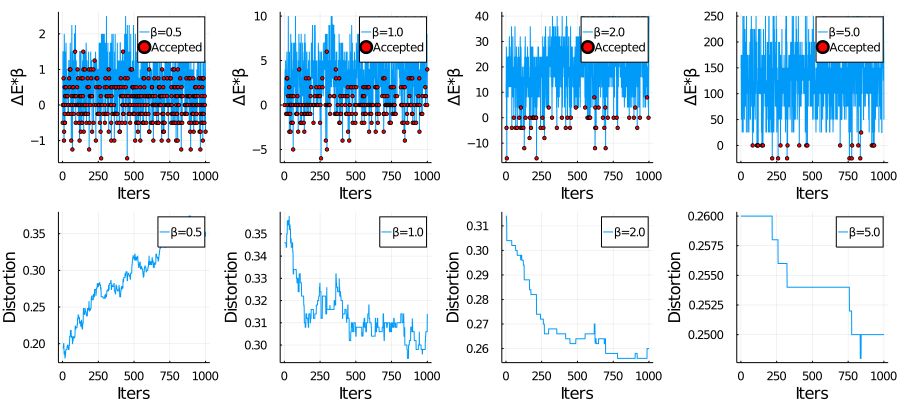

Distortion: 0.18
Naive compression: 0.199
RDB :0.079


In [90]:
steps = 1:nsamples
pl = [Plots.Plot() for b in 1:2*nbetas]
for b in 1:size(algo.betas,1) 
    pl[b] = plot(steps, dE[b]*beta2[b], label="β=$(beta2[b])", xlabel="Iters", ylabel="ΔE*β")
    scatter!(pl[b], steps[accepted[b]], (dE[b]*beta2[b])[accepted[b]], color=:red, ms=2, label="Accepted")
    pl[b+nbetas] = plot(steps, distortions[b], xlabel="Iters", ylabel="Distortion", label="β=$(beta2[b])")
end
display(plot(pl..., layout = (2,nbetas), size=(900,400)))
println("Distortion: ", minimum(minimum.(distortions)))
println("Naive compression: ", naive_compression_inv(rate(lm)))
println("RDB :", round(rdbinv(rate(lm)), digits=3))

## Effect of exposing leaves

In [14]:
q = 2
n = 500
m = 200
bvals = [0, 1, 3, 5, 10, 20, 50, 100]
niter = 10
randseed = 12345;

In [15]:
sims = Vector{Simulation{SA}}(undef, length(bvals))
nbetas = Int(5e4)
beta2 = collect(LinRange(5e-1, 5e0, nbetas))
nsamples = 1
algo = SA(MetropBasisCoeffs(getbasis=lightbasis), beta2, nsamples=nsamples);

In [16]:
for (i,b) in enumerate(bvals)
    println("##### b=$b. $i of $(length(bvals)) #####")
    sims[i] = Simulation(q, n, m, algo, b=b, niter=niter, verbose=true, randseed=randseed+i, showprogress=true)
end

##### b=0. 1 of 8 #####
  1 of 10: Parity 0. Distortion 0.196 at β₁=Inf, β₂=0.506.
  2 of 10: Parity 0. Distortion 0.198 at β₁=Inf, β₂=4.094.
  3 of 10: Parity 0. Distortion 0.158 at β₁=Inf, β₂=3.298.
  4 of 10: Parity 0. Distortion 0.170 at β₁=Inf, β₂=0.511.
  5 of 10: Parity 0. Distortion 0.172 at β₁=Inf, β₂=4.766.
  6 of 10: Parity 0. Distortion 0.176 at β₁=Inf, β₂=0.511.
  7 of 10: Parity 0. Distortion 0.196 at β₁=Inf, β₂=4.284.
  8 of 10: Parity 0. Distortion 0.184 at β₁=Inf, β₂=3.842.
  9 of 10: Parity 0. Distortion 0.162 at β₁=Inf, β₂=0.531.
 10 of 10: Parity 0. Distortion 0.198 at β₁=Inf, β₂=0.513.
##### b=1. 2 of 8 #####
  1 of 10: Parity 0. Distortion 0.188 at β₁=Inf, β₂=4.223.
  2 of 10: Parity 0. Distortion 0.174 at β₁=Inf, β₂=4.159.
  3 of 10: Parity 0. Distortion 0.174 at β₁=Inf, β₂=4.951.
  4 of 10: Parity 0. Distortion 0.186 at β₁=Inf, β₂=4.575.
  5 of 10: Parity 0. Distortion 0.194 at β₁=Inf, β₂=4.606.
  6 of 10: Parity 0. Distortion 0.188 at β₁=Inf, β₂=4.885.
  7 of 1

LoadError: InterruptException:

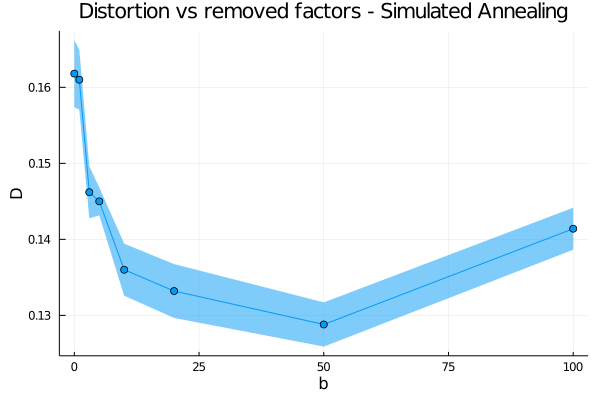

In [12]:
dist = distortion.(sims)
avg_dist = mean.(dist)
sd_dist = std.(dist) ./ sqrt(niter)
pl = Plots.plot(bvals, avg_dist, xlabel="b", ylabel="D", label="", ribbon=sd_dist, marker=:circle)
title!("Distortion vs removed factors - Simulated Annealing")